In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
UPLOAD="./ADX-Calculator/static/upload/data/data.csv"
SAVED="./ADX-Calculator/static/upload/result/data.xlsx"

# Processing data to save solution

In [3]:
def calculateTR(df):
    temp=pd.DataFrame()
    temp['H-L']=df["High"]-df['Low']
    temp["L-PC"]=df['Low']-df["Close"].shift(1)
    temp["H-PC"]=df["High"]-df["Close"].shift(1)
    temp["TR"]=temp.max(axis=1)
    temp["TR"].iloc[0:1]=np.nan
    df["TR"]=temp["TR"].copy(deep=True)
    del temp

In [17]:
def calculateDM(df):
    df["+DM"]=df["High"]
    df["+DM"]=df["+DM"].copy(deep=True).diff()
    filt=df["+DM"]<0
    df["+DM"].loc[filt]=0
    
    df["-DM"]=df["Low"]
    df["-DM"]=(df["-DM"].diff()*(-1))
    filt=df["-DM"]<=0
    df["-DM"].loc[filt]=0

In [12]:
def calculateSmoothed(df):
    tr=[float(x) for x in df["TR"].fillna(0).values]
    prev=sum(tr[0:15])
    tr14=[prev]
    for t in tr[15:]:
        prev=prev-(prev/14)+t
        tr14.append(prev)
        
    p_dm=[float(x) for x in df["+DM"].fillna(0).values]
    prev=sum(p_dm[0:15])
    p_dm14=[prev]
    for t in p_dm[15:]:
        prev=prev-(prev/14)+t
        p_dm14.append(prev)
    
    n_dm=[float(x) for x in df["-DM"].fillna(0).values]
    prev=sum(n_dm[0:15])
    n_dm14=[prev]
    for t in n_dm[15:]:
        prev=prev-(prev/14)+t
        n_dm14.append(prev)
    return [tr14,p_dm14,n_dm14]

In [13]:
def calculateDX(df2):
    df2["+DI"]=(df2['+DM14']/df2["TR14"])*100
    df2["-DI"]=(df2['-DM14']/df2["TR14"])*100
    df2["DI-SUM"]=df2["-DI"]+df2["+DI"]
    df2["DI-DIFF"]=(df2["-DI"]-df2["+DI"]).abs()
    df2["DX"]=(df2["DI-DIFF"]/df2["DI-SUM"])*100

In [14]:
def calculateADX(df2):
    dx=[float(x) for x in df2["DX"].fillna(0).values]
    prev=sum(dx[0:14])/14
    adx=[]
    for i in range(13):
        adx.append(np.nan)
    adx.append(prev)
    for t in dx[14:]:
        prev=((prev*13)+t)/14
        adx.append(prev)
    return adx

In [15]:
def calculate():
    df=pd.read_csv(UPLOAD)
    calculateTR(df)
    calculateDM(df)
    tr14,p_dm14,n_dm14=calculateSmoothed(df)
    df2=df[14:].copy(deep=True)
    df2["TR14"]=tr14
    df2["+DM14"]=p_dm14
    df2["-DM14"]=n_dm14
    calculateDX(df2)
    adx=calculateADX(df2)
    df2["ADX"]=adx
    
    final_df=df.join(df2.loc[:,"TR14":])
    final_df=final_df.round(2)
    final_df.to_excel(SAVED,index=False)

In [16]:
calculate()

# Preparing data for graph

In [18]:
df=pd.read_excel(SAVED)
filt=df["ADX"]>0
df=df.loc[filt]

In [19]:
df['Time']=df.iloc[:,:1]
df['Time']=pd.to_datetime(df["Time"],format='%Y-%m-%d %H:%M:%S')

In [20]:
df['Date']=df['Time'].dt.date

In [21]:
tempDF=df.groupby('Date').mean()[['+DI','-DI','ADX']]

In [22]:
df2=pd.DataFrame()
df2['Date']=pd.date_range(start =df['Date'].min(), 
         end =df['Date'].max(), freq ='1d')
df2.set_index('Date',inplace=True)

In [23]:
df2=df2.join(tempDF)
df2

,+DI,-DI,ADX
Date,,,
2017-09-01,26.977778,24.532037,28.723148
2017-09-02,NaN,NaN,NaN
2017-09-03,NaN,NaN,NaN
2017-09-04,27.275062,25.003580,18.769506
2017-09-05,38.257037,18.415309,34.881111
2017-09-06,27.617160,22.761605,22.146420
2017-09-07,23.429012,26.752716,19.404321
2017-09-08,20.972469,29.750988,19.717654
2017-09-09,NaN,NaN,NaN


### Filled NaN values with mean of the column

In [20]:
df2=df2.fillna(df2.mean()).reset_index().round(2)
df2.head(15)

,Date,+DI,-DI,ADX
0,2017-09-01,26.98,24.53,28.72
1,2017-09-02,26.28,22.36,25.97
2,2017-09-03,26.28,22.36,25.97
3,2017-09-04,27.28,25.00,18.77
4,2017-09-05,38.26,18.42,34.88
5,2017-09-06,27.62,22.76,22.15
6,2017-09-07,23.43,26.75,19.40
7,2017-09-08,20.97,29.75,19.72
8,2017-09-09,26.28,22.36,25.97
9,2017-09-10,26.28,22.36,25.97


# PLOTTING DATA

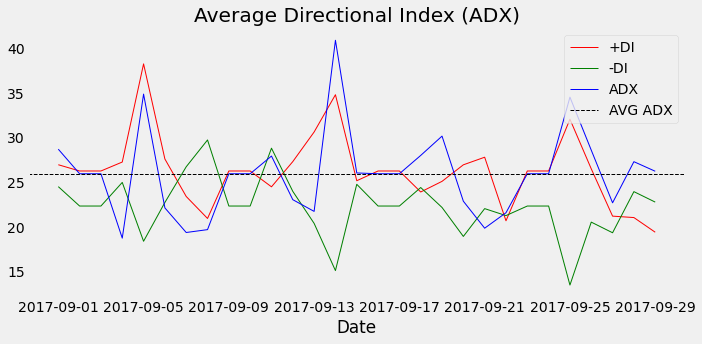

In [21]:
plt.style.use('fivethirtyeight')
f = plt.figure()
f.set_figwidth(10)
f.set_figheight(5)
plt.plot(df2['Date'],df2['+DI'],color="r",linewidth=1,label='+DI')

plt.plot(df2['Date'],df2['-DI'],color="g",linewidth=1,label='-DI')

plt.plot(df2['Date'],df2['ADX'],color="b",linewidth=1,label='ADX')

# plt.axhline(x=df2['ADX'].mean(),'--k',linewidth=3,label='ADX')
plt.axhline(y = df2['ADX'].mean(), color = 'k', linestyle = 'dashed',linewidth=1,label='AVG ADX')

plt.title('Average Directional Index (ADX)')
plt.xlabel('Date')
# plt.ylabel('Date')
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

# Data for API (Graph.js)

In [34]:
def getValues(df):
    pdi=df['+DI'].values
    ndi=df['-DI'].values
    adx=df['ADX'].values
    adx_mean=df2['ADX'].mean()
    return {
        'Date':[str(x) for x in df2['Date'].dt.date.values],
        'ADX': [float(x) for x in df['ADX'].values], 
        "+Di": [float(x) for x in df['+DI'].values],
        "-DI": [float(x) for x in df['-DI'].values],
        "ADX_MEAN": round(df2['ADX'].mean(), 2)
    }
getValues(df2)

{'Date': ['2017-09-01', '2017-09-02', '2017-09-03', '2017-09-04', '2017-09-05', '2017-09-06', '2017-09-07', '2017-09-08', '2017-09-09', '2017-09-10', '2017-09-11', '2017-09-12', '2017-09-13', '2017-09-14', '2017-09-15', '2017-09-16', '2017-09-17', '2017-09-18', '2017-09-19', '2017-09-20', '2017-09-21', '2017-09-22', '2017-09-23', '2017-09-24', '2017-09-25', '2017-09-26', '2017-09-27', '2017-09-28', '2017-09-29'], 'ADX': [28.72, 25.97, 25.97, 18.77, 34.88, 22.15, 19.4, 19.72, 25.97, 25.97, 27.95, 23.07, 21.76, 40.9, 26.06, 25.97, 25.97, 28.02, 30.18, 22.9, 19.88, 21.61, 25.97, 25.97, 34.54, 28.61, 22.72, 27.32, 26.25], '+Di': [26.98, 26.28, 26.28, 27.28, 38.26, 27.62, 23.43, 20.97, 26.28, 26.28, 24.51, 27.33, 30.64, 34.81, 25.19, 26.28, 26.28, 23.93, 25.12, 26.97, 27.82, 20.71, 26.28, 26.28, 32.07, 26.52, 21.23, 21.07, 19.43], '-DI': [24.53, 22.36, 22.36, 25.0, 18.42, 22.76, 26.75, 29.75, 22.36, 22.36, 28.83, 24.0, 20.42, 15.14, 24.79, 22.36, 22.36, 24.43, 22.2, 18.96, 22.07, 21.29, 22.

In [32]:
round(df2['ADX'].mean(),2)

25.97